<a href="https://colab.research.google.com/github/AdrianDiez/Maingear-Estimator/blob/main/Maingear_Estimates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maingear Estimator

Given the low availability of data after some research it was found that using logarithmic regression would be the most addecuate given the simplicity of the task and the amount of information in the dataset.
Source: [The Best Classifier for Small Datasets: Log-F(m,m) Logit](https://medium.com/@remycanario17/log-f-m-m-logit-the-best-classification-algorithm-for-small-datasets-fc92fd95bc58)

## Dependencies
The first step is to gather all necesary dependencies, in this case we would be reading from a Google Spreadsheet and converting the information as needed.

Documentation: [Read from sheets](https://developers.google.com/sheets/api/quickstart/python)

In [ ]:
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

     |████████████████████████████████| 7.0MB 9.1MB/s 
Requirement already up-to-date: google-auth-oauthlib in /usr/local/lib/python3.7/dist-packages (0.4.4)
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 2.2.0 which is incompatible.
  Found existing installation: google-auth-httplib2 0.0.4
    Uninstalling google-auth-httplib2-0.0.4:
      Successfully uninstalled google-auth-httplib2-0.0.4
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gspread

from google.colab import auth
from oauth2client.client import GoogleCredentials

In [92]:
dataset_url = 'https://docs.google.com/spreadsheets/d/1z6sD5_iGArHKal-hdd2BZkHuPhRJ47Xfu3ET1D0fj0E/edit?ts=60463182#gid=1539062128' 
tab_name = 'All Builds'
critical_columns = ['RIG', 'APEX', 'BUILD', 'CPU', 'GPU']
column_name = {'APEX?' : 'APEX', 'Rig' : 'RIG', 'Build' : 'BUILD', 'User' : 'USER','Assembled ?' : 'COMPLETED', 
               'Paint?' : 'PAINT', 'Ordered Date' : 'ORDERED_DATE', 'Completed Date' : 'COMPLETED_DATE', 'Days' : 'DAYS'}
#if the dataset is moved but the structure is the same this could be pointed to other links or other tabs.

In [130]:
auth.authenticate_user() 
# This step will ask you to go into a link and approve the access to this tool. Don't do it if you don't feel confortable. You can search in internet, this is standard from Google.

gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url(dataset_url) 
sheet = wb.worksheet(tab_name) 

data = sheet.get_all_values()[2:] # We skip the first two rows, no data 
orig_df = pd.DataFrame(data[1:]) # Skipping the header
orig_df.columns = data[0] # Setting up the header
orig_df = orig_df.rename(columns=column_name)

orig_df = orig_df.applymap(lambda s:s.lower() if type(s) == str else s) # All to lowercase so I don't go crazy
orig_df = orig_df.applymap(lambda s:s.rstrip('?') if type(s) == str else s) # Removing ? just in case

clean_df = orig_df.replace(r'^\s*$', np.nan, regex=True).dropna(subset=critical_columns) # Converting blanks to NaN and droping rows with NaN in critical values. (see above)
clean_df['USER'] = clean_df['USER'].apply(hash) # Hashing Usernames :)
clean_df['GPU'] = clean_df['GPU'].map(lambda x: x.rstrip('x2').strip()).to_list() # Removing dual 3090, residual population
clean_df['DAYS'] = clean_df['DAYS'].astype(int)
###### There are records which are dropped because of NaN. !!!!!!!!!!

In [131]:
# We split the dataset between completed status

mask = clean_df['COMPLETED'] == 'true'
completed_df = clean_df[mask]
not_completed_df = clean_df[~mask]

In [157]:
avg_dict = {}

for col in critical_columns:
  sup_dict = {}
  avg_dict[col] = sup_dict
  for val in completed_df[col].unique():
    mask = completed_df[col] == val
    sup_dict[val] = round(completed_df[mask]['DAYS'].mean())

In [165]:
avg_dict['GPU']

{'2060': 81, '3060 ti': 50, '3070': 59, '3080': 74, '3090': 110, '6800xt': 87}

In [129]:
completed_df['DAYS'].astype(int).mean()

76.48958333333333

In [233]:
def paint_dict(data_dict, x_label):
  plt.rcParams['axes.edgecolor']='#333F4B'
  plt.rcParams['axes.linewidth']=0.8
  plt.rcParams['xtick.color']='#333F4B'
  plt.rcParams['ytick.color']='#333F4B'

  fig, ax = plt.subplots(figsize=(15,10))

  ax.set_ylabel('Days', fontsize=15, fontweight='black', color = '#333F4B')
  ax.set_xlabel(x_label, fontsize=15, fontweight='black', color = '#333F4B')

  fig.text(-0.23, 0.96, 'Average time by ' + x_label, fontsize=15, fontweight='black', color = '#333F4B')

  ax.bar(range(len(data_dict)), list(data_dict.values()), align='center', color='#007ACC', alpha=0.4, width=.2)
  ax.spines['left'].set_position(('outward', 8))
  ax.spines['bottom'].set_position(('outward', 5))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  values = list(data_dict.values())
  for i, v in enumerate(values):
      ax.text(i - .05, v/values[i], values[i], fontsize=10, color='#333F4B')
    
  plt.xticks(range(len(data_dict)), list(data_dict.keys()))
  plt.show()

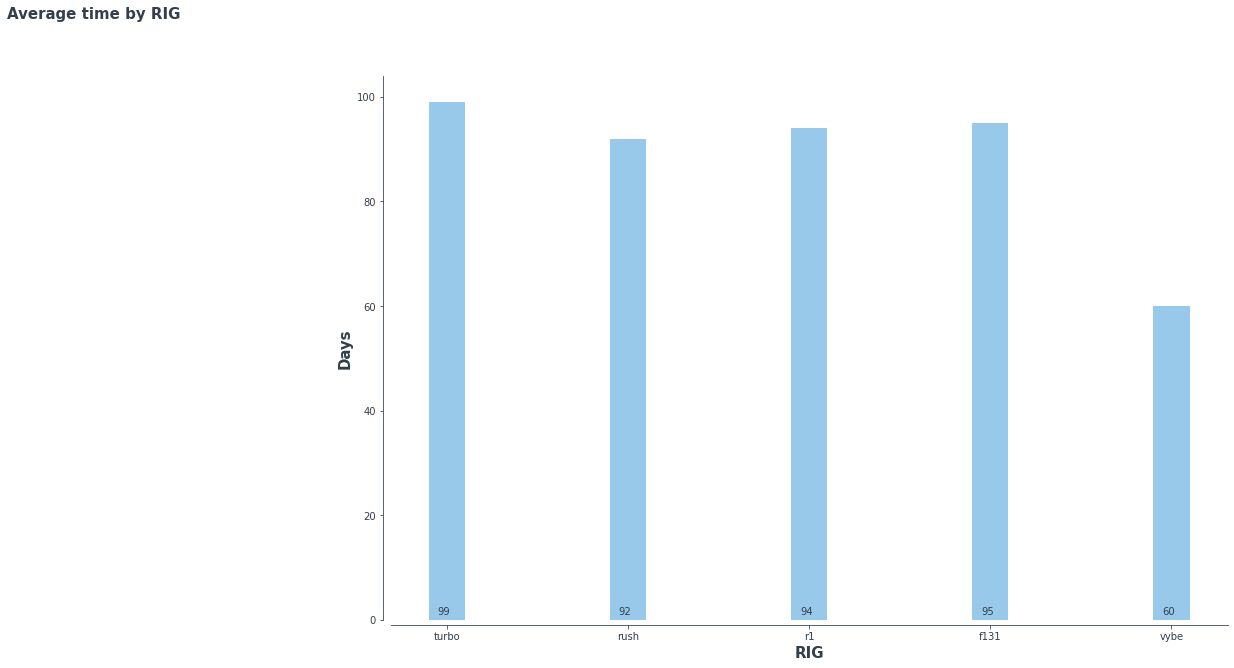

In [242]:
paint_dict(avg_dict['RIG'], 'RIG')

In [241]:
avg_dict

{'APEX': {'no': 62, 'yes': 117},
 'BUILD': {'custom': 93,
  'stage 3': 42,
  'stage 4': 42,
  'stage 4 (boost)': 44,
  'stage bf': 56},
 'CPU': {'10900k': 98,
  '3970x': 127,
  '5600x': 53,
  '5800x': 74,
  '5900x': 75,
  '5900x ': 57,
  '5950x': 96},
 'GPU': {'2060': 81,
  '3060 ti': 50,
  '3070': 59,
  '3080': 74,
  '3090': 110,
  '6800xt': 87},
 'RIG': {'f131': 95, 'r1': 94, 'rush': 92, 'turbo': 99, 'vybe': 60}}

In [180]:
avg_dict['GPU'].values()

dict_values([74, 110, 87, 81, 59, 50])

In [181]:
avg_dict['GPU'].keys()

dict_keys(['3080', '3090', '6800xt', '2060', '3070', '3060 ti'])

In [ ]:

# set labels
ax.set_xlabel('Days', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, avg_dict['GPU'].keys())

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'GPU', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, my_range))
ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))